# Загрузка библиотек

In [ ]:
!pip install autokeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.5/576.5 kB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.0/728.0 kB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 23.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: ten

In [ ]:
import zipfile
import os
from sklearn.model_selection import train_test_split
import shutil
import random
from PIL import Image
from collections import defaultdict # для подсчета изображений

import autokeras as ak
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras as keras

import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical


Using TensorFlow backend


# Загрузка и подготовка данных

In [ ]:
from google.colab import drive

# Монтирование Google Диска
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Путь к архиву с изображениями
zip_path = '/content/drive/MyDrive/glasses_3class.zip'

# Папка, в которую будут распакованы изображения
extract_path = 'glasses_images'

# Распаковка архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Проверка содержимого папки с распакованными изображениями
image_folders = os.listdir(extract_path)
print(image_folders)

['Леска', 'Ободки', 'Втулки']


In [ ]:
# Путь к папке с изображениями
folder_path = "glasses_images"

# Список подпапок
subfolders = ["Втулки", "Леска", "Ободки"]

# Создание папок для train и val выборок
train_folder = "train_folder"
val_folder = "val_folder"
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Проход по каждой подпапке, разделение на train и val выборки
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    image_files = os.listdir(subfolder_path)
    num_images = len(image_files)
    num_train = int(0.8 * num_images)  # Количество изображений для train
    num_val = num_images - num_train  # Количество изображений для val
    print(f"Папка {subfolder} содержит {num_images} изображений")

    # Перемешивание изображений
    random.shuffle(image_files)

    # Разделение изображений на train и val
    train_images = image_files[:num_train]
    val_images = image_files[num_train:]

    # Создание папок train и val для текущей подпапки, если они не существуют
    train_subfolder_path = os.path.join(train_folder, subfolder)
    val_subfolder_path = os.path.join(val_folder, subfolder)
    os.makedirs(train_subfolder_path, exist_ok=True)
    os.makedirs(val_subfolder_path, exist_ok=True)

    # Копирование изображений в папки train и val
    for image_file in train_images:
        source_path = os.path.join(subfolder_path, image_file)
        destination_path = os.path.join(train_subfolder_path, image_file)
        shutil.copyfile(source_path, destination_path)

    for image_file in val_images:
        source_path = os.path.join(subfolder_path, image_file)
        destination_path = os.path.join(val_subfolder_path, image_file)
        shutil.copyfile(source_path, destination_path)

print("Разделение на выборки завершено.")


Папка Втулки содержит 397 изображений
Папка Леска содержит 480 изображений
Папка Ободки содержит 498 изображений
Разделение на выборки завершено.


Вывод изображений

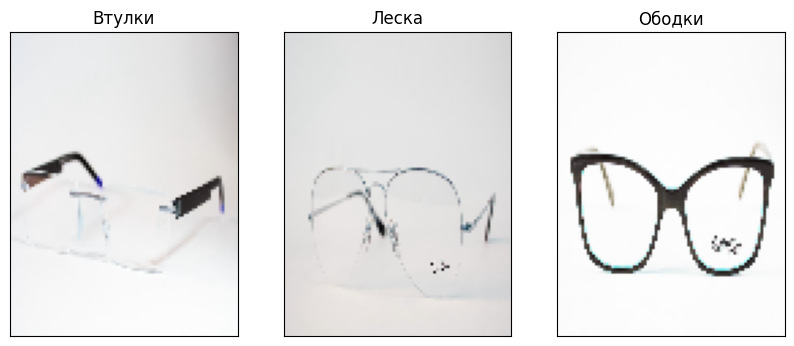

In [ ]:
class_names = ['Втулки', 'Леска', 'Ободки']

fig = plt.figure(figsize=(10,10))
for i in range(3):
    ax = fig.add_subplot(1, 3, 1 + i, xticks=[], yticks=[])
    idx = np.where(np.argmax(y_train, axis=-1) == i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()


Узнаем размеры изображений

In [ ]:
# Получение размеров изображений
extract_path = '/content'
split_folders = ['train_folder', 'val_folder']
class_names = ['Втулки', 'Леска', 'Ободки']

# Словарь для подсчета количества изображений по форматам
image_counts = defaultdict(int)

# Подсчет количества изображений по размерам
for split_folder in split_folders:
    for class_name in class_names:
        folder_path = os.path.join(extract_path, split_folder, class_name)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                image_size = img.size
                image_counts[image_size] += 1

# Вывод результатов подсчета
for size, count in image_counts.items():
    print(f"Размер: {size}, Количество изображений: {count}")

Размер: (675, 450), Количество изображений: 693
Размер: (3775, 2831), Количество изображений: 20
Размер: (2876, 2157), Количество изображений: 1
Размер: (3575, 2681), Количество изображений: 26
Размер: (900, 600), Количество изображений: 340
Размер: (3564, 2673), Количество изображений: 6
Размер: (3089, 2317), Количество изображений: 2
Размер: (4352, 3264), Количество изображений: 6
Размер: (899, 599), Количество изображений: 1
Размер: (3210, 2408), Количество изображений: 1
Размер: (3188, 2391), Количество изображений: 10
Размер: (3894, 2920), Количество изображений: 10
Размер: (3519, 2639), Количество изображений: 5
Размер: (889, 593), Количество изображений: 3
Размер: (3587, 2690), Количество изображений: 4
Размер: (3340, 2505), Количество изображений: 13
Размер: (2988, 2241), Количество изображений: 10
Размер: (3032, 2274), Количество изображений: 4
Размер: (3484, 2613), Количество изображений: 16
Размер: (3122, 2341), Количество изображений: 12
Размер: (2824, 2118), Количество изо

In [ ]:
# посмотрим на самый минимальный размер изображения

min_size = min(image_counts.keys())

# Вывести самый минимальный размер и количество изображений с этим размером
print(f"Самый минимальный размер: {min_size}, Количество изображений: {image_counts[min_size]}")


Самый минимальный размер: (648, 450), Количество изображений: 2


Подготовим данные для подачи в AutoKeras, задавая размер изображений максимально приближенный к самому маленькому размеру, выявленному из реальных изображений

In [ ]:
# Список категорий
categories = ['Втулки', 'Леска', 'Ободки']

# Размер изображений (предположим, что все изображения имеют одинаковый размер)
# image_size = (640, 448)
image_size = (84, 112)    # уменьшим размер изображения, для оперативного обучения


# Создание пустых списков для x_train и y_train
x_train = []
y_train = []

# Проход по категориям
for category_id, category in enumerate(categories):
    category_path = os.path.join(train_folder, category)

    # Проход по файлам в каждой категории
    for filename in os.listdir(category_path):
        image_path = os.path.join(category_path, filename)

        # Загрузка изображения с помощью OpenCV
        image = cv2.imread(image_path)

        # Изменение размера изображения
        image = cv2.resize(image, image_size)

        # Преобразуем изображение в ч/б цвет
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Добавление изображения в x_train
        x_train.append(image)

        # Добавление метки в y_train
        y_train.append(category_id)

# Преобразование списков в массивы NumPy
x_train = np.array(x_train)
y_train = np.array(y_train)

# Преобразование меток в one-hot кодирование с помощью to_categorical
y_train = to_categorical(y_train, num_classes=3)

# Вывод размеров x_train и y_train
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (1099, 112, 84, 3)
y_train shape: (1099, 3)


In [ ]:
# Размер изображений (предположим, что все изображения имеют одинаковый размер)
# image_size = (640, 448)
image_size = (84, 112)

# Создание пустых списков для x_val и y_val
x_val = []
y_val = []

# Проход по категориям
for category_id, category in enumerate(categories):
    category_path = os.path.join(val_folder, category)

    # Проход по файлам в каждой категории
    for filename in os.listdir(category_path):
        image_path = os.path.join(category_path, filename)

        # Загрузка изображения с помощью OpenCV
        image = cv2.imread(image_path)

        # Изменение размера изображения
        image = cv2.resize(image, image_size)

        # Преобразуем изображение в ч/б цвет
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Добавление изображения в x_val
        x_val.append(image)

        # Добавление метки в y_val
        y_val.append(category_id)

# Преобразование списков в массивы NumPy
x_val = np.array(x_val)
y_val = np.array(y_val)

# Преобразование меток в one-hot кодирование с помощью to_categorical
y_val = to_categorical(y_val, num_classes=3)

# Вывод размеров x_val и y_val
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_val shape: (276, 112, 84, 3)
y_val shape: (276, 3)


In [ ]:
# Нормализация данных
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.

In [ ]:
# Проверка размерностей массивов
print("Размерности массивов:")
print("x_train:", x_train.shape)
print("x_val:", x_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

Размерности массивов:
x_train: (1099, 112, 84, 3)
x_val: (276, 112, 84, 3)
y_train: (1099, 3)
y_val: (276, 3)


# AutoKeras

## Базовые настройки AutoKeras

### Запуск 1

Точность на проверочной выборке 91%. При попытке дообучить модель идет переобучение

In [ ]:
# Инициализация классификатора AutoKeras
clf = ak.ImageClassifier(
    max_trials=10,
    objective='val_accuracy',
    directory='/content/drive/MyDrive/NetOptik',
    overwrite=True)

clf.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Сохраним как Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("model_autokeras2", save_format="tf")
except Exception:
    model.save("model_autokeras2.h5")


loaded_model = load_model("model_autokeras2", custom_objects=ak.CUSTOM_OBJECTS)

predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

Trial 10 Complete [00h 00m 24s]
val_accuracy: 0.8152173757553101

Best val_accuracy So Far: 0.8152173757553101
Total elapsed time: 00h 22m 04s
Epoch 1/10
35/35 [==============================] - 3s 49ms/step - loss: 14.0061 - accuracy: 0.4231 - val_loss: 1.0860 - val_accuracy: 0.3623
Epoch 2/10
35/35 [==============================] - 1s 40ms/step - loss: 1.1130 - accuracy: 0.3685 - val_loss: 1.0981 - val_accuracy: 0.3623
Epoch 3/10
35/35 [==============================] - 1s 40ms/step - loss: 1.0972 - accuracy: 0.3640 - val_loss: 1.0963 - val_accuracy: 0.3623
Epoch 4/10
35/35 [==============================] - 1s 40ms/step - loss: 1.0927 - accuracy: 0.3621 - val_loss: 1.0906 - val_accuracy: 0.3623
Epoch 5/10
35/35 [==============================] - 1s 40ms/step - loss: 1.0790 - accuracy: 0.3621 - val_loss: 1.0657 - val_accuracy: 0.3768
Epoch 6/10
35/35 [==============================] - 2s 44ms/step - loss: 1.0384 - accuracy: 0.3858 - val_loss: 1.0022 - val_accuracy: 0.4203
Epoch 7/10

In [ ]:
# дообучаем лучшую модель
history = model.fit(x_train, y_train, epochs=5)


Epoch 1/5
35/35 [==============================] - 3s 37ms/step - loss: 0.4641 - accuracy: 0.8116
Epoch 2/5
35/35 [==============================] - 1s 35ms/step - loss: 0.2049 - accuracy: 0.9272
Epoch 3/5
35/35 [==============================] - 1s 36ms/step - loss: 0.1166 - accuracy: 0.9618
Epoch 4/5
35/35 [==============================] - 1s 36ms/step - loss: 0.0727 - accuracy: 0.9827
Epoch 5/5
35/35 [==============================] - 1s 35ms/step - loss: 0.0315 - accuracy: 0.9927


In [ ]:
model.save_weights('weights_1_acc_0.99.h5')
model.save('model_1_acc_0.99.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 84, 3)]      0         
                                                                 
 cast_to_float32 (CastToFlo  (None, 112, 84, 3)        0         
 at32)                                                           
                                                                 
 normalization (Normalizati  (None, 112, 84, 3)        7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 110, 82, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 80, 128)      36992     
                                                                 
 max_pooling2d (MaxPooling2  (None, 54, 40, 128)       0     

In [ ]:
# архитектура модели в виде JSON строки
model_json = model.to_json()

print("Model architecture:")
print(model_json)

Model architecture:
{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 112, 84, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Custom>CastToFloat32", "config": {"name": "cast_to_float32", "trainable": true, "dtype": "float32"}, "name": "cast_to_float32", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Normalization", "config": {"name": "normalization", "trainable": true, "dtype": "float32", "axis": [-1], "invert": false, "mean": null, "variance": null}, "name": "normalization", "inbound_nodes": [[["cast_to_float32", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu

Epoch 1/300
35/35 [==============================] - 2s 53ms/step - loss: 0.0118 - accuracy: 0.9982 - val_loss: 0.4731 - val_accuracy: 0.9167
Epoch 2/300
35/35 [==============================] - 1s 42ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.5224 - val_accuracy: 0.9058
Epoch 3/300
35/35 [==============================] - 1s 42ms/step - loss: 0.0084 - accuracy: 0.9991 - val_loss: 0.5196 - val_accuracy: 0.9094
Epoch 4/300
35/35 [==============================] - 1s 41ms/step - loss: 0.0067 - accuracy: 0.9991 - val_loss: 0.5155 - val_accuracy: 0.9022
Epoch 5/300
35/35 [==============================] - 1s 40ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.5474 - val_accuracy: 0.9094
Epoch 6/300
35/35 [==============================] - 1s 40ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.5515 - val_accuracy: 0.9022
Epoch 7/300
35/35 [==============================] - 1s 40ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.5213 - val_accuracy: 0.9130
Epoch 

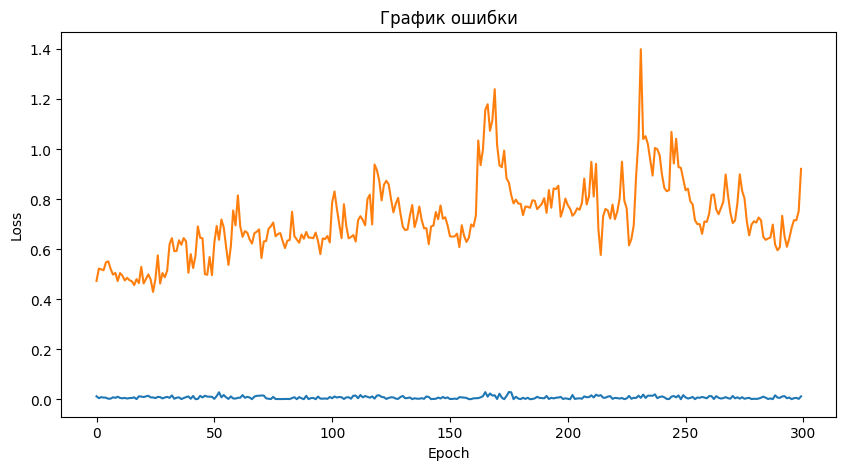

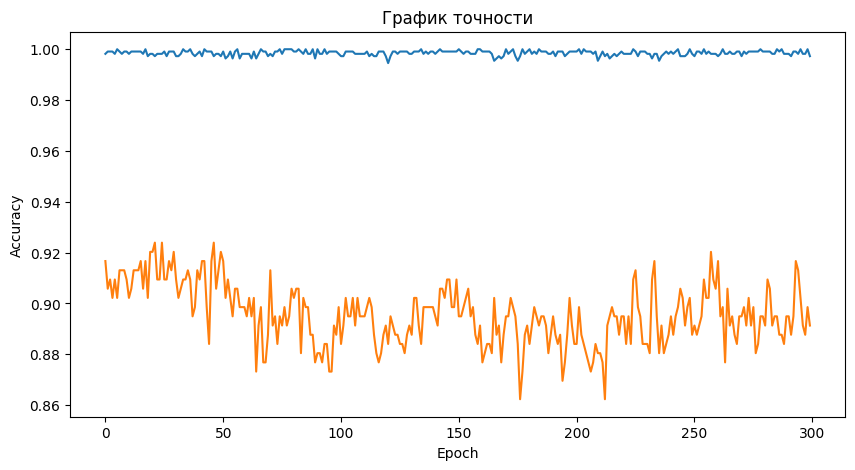

In [ ]:
# дообучаем лучшую модель
history = model.fit(x_train, y_train, epochs=300, batch_size=32, validation_data=(x_val, y_val))

# Вывод графика loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.title('График ошибки')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Вывод графика accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.title('График точности')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Запуск 2

ТОЧНОСЬ НА ПРОВЕРОЧНОЙ ВЫБОРКЕ 89%. При попытке дообучить модель, точность плавает около 90%



In [ ]:
# Инициализация классификатора AutoKeras
clf = ak.ImageClassifier(
    max_trials=3,
    objective='val_accuracy',
    directory='/content/drive/MyDrive/NetOptik/AK2',
    overwrite=True)

clf.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

# Сохраним как Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

model.save("model_autokeras3", save_format="tf")


loaded_model = load_model("model_autokeras3", custom_objects=ak.CUSTOM_OBJECTS)

predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

Trial 3 Complete [00h 40m 21s]
val_accuracy: 0.760869562625885

Best val_accuracy So Far: 0.8586956262588501
Total elapsed time: 00h 49m 29s
Epoch 1/30
35/35 [==============================] - 3s 36ms/step - loss: 13.1705 - accuracy: 0.4477 - val_loss: 1.0700 - val_accuracy: 0.4746
Epoch 2/30
35/35 [==============================] - 1s 26ms/step - loss: 1.1235 - accuracy: 0.3685 - val_loss: 1.0972 - val_accuracy: 0.3659
Epoch 3/30
35/35 [==============================] - 1s 25ms/step - loss: 1.0978 - accuracy: 0.3685 - val_loss: 1.0913 - val_accuracy: 0.3623
Epoch 4/30
35/35 [==============================] - 1s 25ms/step - loss: 1.0718 - accuracy: 0.3312 - val_loss: 1.0162 - val_accuracy: 0.3623
Epoch 5/30
35/35 [==============================] - 1s 25ms/step - loss: 0.9868 - accuracy: 0.3803 - val_loss: 0.9176 - val_accuracy: 0.3913
Epoch 6/30
35/35 [==============================] - 1s 25ms/step - loss: 2.1009 - accuracy: 0.4377 - val_loss: 0.9776 - val_accuracy: 0.4457
Epoch 7/30
3

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 84, 3)]      0         
                                                                 
 cast_to_float32 (CastToFlo  (None, 112, 84, 3)        0         
 at32)                                                           
                                                                 
 normalization (Normalizati  (None, 112, 84, 3)        7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 110, 82, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 80, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 54, 40, 64)        0     

Epoch 1/30
35/35 [==============================] - 1s 32ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.5178 - val_accuracy: 0.8986
Epoch 2/30
35/35 [==============================] - 1s 35ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.7784 - val_accuracy: 0.8659
Epoch 3/30
35/35 [==============================] - 1s 26ms/step - loss: 0.0080 - accuracy: 0.9955 - val_loss: 0.8641 - val_accuracy: 0.8841
Epoch 4/30
35/35 [==============================] - 1s 27ms/step - loss: 0.0232 - accuracy: 0.9936 - val_loss: 0.6798 - val_accuracy: 0.8768
Epoch 5/30
35/35 [==============================] - 1s 27ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.6653 - val_accuracy: 0.8986
Epoch 6/30
35/35 [==============================] - 1s 29ms/step - loss: 0.0214 - accuracy: 0.9964 - val_loss: 0.6879 - val_accuracy: 0.8841
Epoch 7/30
35/35 [==============================] - 1s 26ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5869 - val_accuracy: 0.8913
Epoch 8/30
35

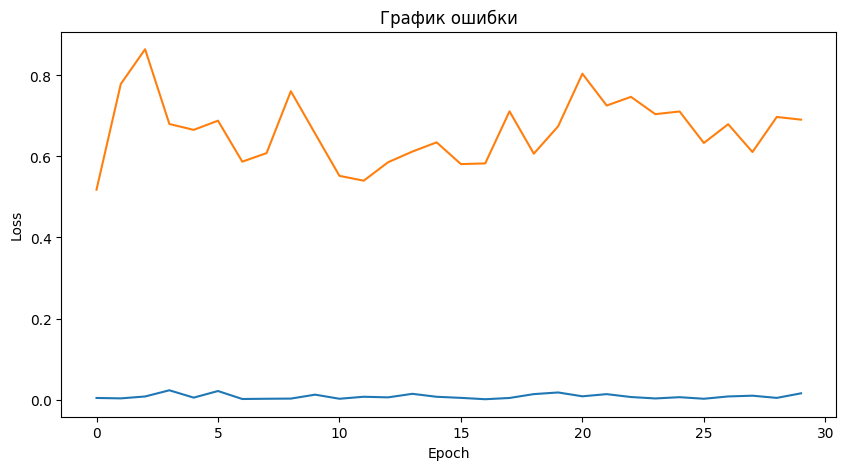

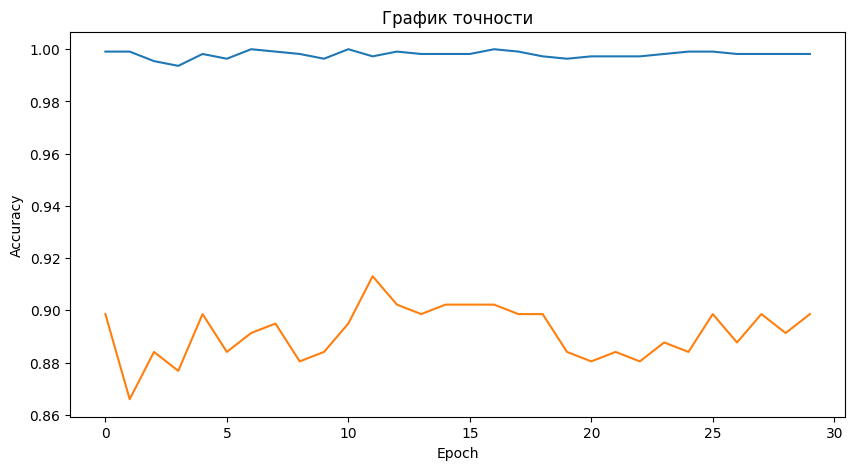

In [ ]:
# дообучаем лучшую модель
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

# Вывод графика loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.title('График ошибки')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Вывод графика accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.title('График точности')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Среди 10 вариантов моделей, которые опробовал AutoKeras, был 3 вариант, дававший стабильный рост точности и стабильное снижение ошибки.

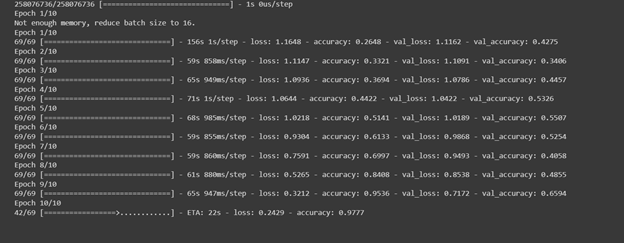

На 10 эпохах обучения эта модель не достигла самых высоких результатов. Поэтому дообучим ее и посмотрим.

In [ ]:
import json
import pandas as pd

In [ ]:
with open('/content/drive/MyDrive/NetOptik/image_classifier/trial_01/trial.json') as file:
    trial3_model = json.load(file)

In [ ]:
print(trial3_model['hyperparameters'])

{'space': [{'class_name': 'Boolean', 'config': {'name': 'image_block_1/normalize', 'default': False, 'conditions': []}}, {'class_name': 'Boolean', 'config': {'name': 'image_block_1/augment', 'default': False, 'conditions': []}}, {'class_name': 'Choice', 'config': {'name': 'image_block_1/block_type', 'default': 'resnet', 'conditions': [], 'values': ['resnet', 'xception', 'vanilla', 'efficient'], 'ordered': False}}, {'class_name': 'Boolean', 'config': {'name': 'image_block_1/res_net_block_1/pretrained', 'default': False, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'image_block_1/block_type', 'values': ['resnet']}}]}}, {'class_name': 'Choice', 'config': {'name': 'image_block_1/res_net_block_1/version', 'default': 'resnet50', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'image_block_1/block_type', 'values': ['resnet']}}], 'values': ['resnet50', 'resnet101', 'resnet152', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2'], 'ordered': False}}, {'class_name': 'Boolean'

In [ ]:
print(trial3_model['hyperparameters']['space'])


[{'class_name': 'Boolean', 'config': {'name': 'image_block_1/normalize', 'default': False, 'conditions': []}}, {'class_name': 'Boolean', 'config': {'name': 'image_block_1/augment', 'default': False, 'conditions': []}}, {'class_name': 'Choice', 'config': {'name': 'image_block_1/block_type', 'default': 'resnet', 'conditions': [], 'values': ['resnet', 'xception', 'vanilla', 'efficient'], 'ordered': False}}, {'class_name': 'Boolean', 'config': {'name': 'image_block_1/res_net_block_1/pretrained', 'default': False, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'image_block_1/block_type', 'values': ['resnet']}}]}}, {'class_name': 'Choice', 'config': {'name': 'image_block_1/res_net_block_1/version', 'default': 'resnet50', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'image_block_1/block_type', 'values': ['resnet']}}], 'values': ['resnet50', 'resnet101', 'resnet152', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2'], 'ordered': False}}, {'class_name': 'Boolean', 'config'

In [ ]:
print(trial3_model['hyperparameters']['space'][1])

{'class_name': 'Boolean', 'config': {'name': 'image_block_1/augment', 'default': False, 'conditions': []}}


In [ ]:
space_data = trial3_model['hyperparameters']['space']

# Создадим пустой список для хранения блоков 'config'
config_blocks = []

# Извлекаем каждый блок 'config' из space_data и добавляем его в список config_blocks
for item in space_data:
    config_blocks.append(item['config'])

# Создаем DataFrame из списка
df = pd.DataFrame(config_blocks)

# Выведите DataFrame
print(df)


                                                 name   default  \
0                             image_block_1/normalize     False   
1                               image_block_1/augment     False   
2                            image_block_1/block_type    resnet   
3            image_block_1/res_net_block_1/pretrained     False   
4               image_block_1/res_net_block_1/version  resnet50   
5         image_block_1/res_net_block_1/imagenet_size     False   
6   classification_head_1/spatial_reduction_1/redu...   flatten   
7                       classification_head_1/dropout         0   
8                                           optimizer      adam   
9                                       learning_rate     0.001   
10             image_block_1/conv_block_1/kernel_size         3   
11               image_block_1/conv_block_1/separable     False   
12             image_block_1/conv_block_1/max_pooling      True   
13              image_block_1/conv_block_1/num_blocks         

In [ ]:
# Сохраняем данные
df.to_csv('trial2.csv', index=False)
df.to_excel('trial2.xlsx', index=False)

In [ ]:
# Подгружаем сохраненную модель
model = tf.saved_model.load('/content/drive/MyDrive/NetOptik/image_classifier/trial_03')

In [ ]:
best_model = clf.export_model()
# Получите архитектуру модели в виде JSON строки
model_json = best_model.to_json()

print("Model architecture:")
print(model_json)

try:
    model.save("model_autokeras2", save_format="tf")
except Exception:
    model.save("model_autokeras2.h5")


loaded_model = load_model("model_autokeras2", custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

In [ ]:
# Export as a Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("model_autokeras_greedy2", save_format="tf")
except Exception:
    model.save("model_autokeras_greedy2.h5")


loaded_model = load_model("model_autokeras_greedy2", custom_objects=ak.CUSTOM_OBJECTS)

predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

In [ ]:
# дообучаем лучшую модель
model.fit(x_train, y_train, epochs=30)

# Вывод графика loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.title('График ошибки')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Вывод графика accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.title('График точности')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


## Greedy1 без аугментации
точность 0,93

x_train и x_val нормализованы и y_train и y_val  преобразованы в OHE с указанием 3-х классов.



batch_size=32, т.к. памяти в предыдущем прогоне на 64 батча не хватало

In [ ]:
# Инициализируем классификатор изображений
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=3,
    objective='val_accuracy',
    tuner='greedy'
)

# Подаем изображение в классификатор для обучения
clf.fit(x_train, y_train, epochs=10, batch_size=32)

# Сохраним как Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("model_autokeras_greedy", save_format="tf")
except Exception:
    model.save("model_autokeras_greedy.h5")


loaded_model = load_model("model_autokeras_greedy", custom_objects=ak.CUSTOM_OBJECTS)

predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

Trial 3 Complete [00h 02m 09s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 08m 06s
Epoch 1/10
35/35 [==============================] - 44s 92ms/step - loss: 10.3209 - accuracy: 0.6897
Epoch 2/10
35/35 [==============================] - 3s 92ms/step - loss: 20.5761 - accuracy: 0.3039
Epoch 3/10
35/35 [==============================] - 3s 90ms/step - loss: 8.0138 - accuracy: 0.4149
Epoch 4/10
35/35 [==============================] - 3s 90ms/step - loss: 6.0862 - accuracy: 0.4258
Epoch 5/10
35/35 [==============================] - 3s 93ms/step - loss: 4.5934 - accuracy: 0.4904
Epoch 6/10
35/35 [==============================] - 3s 92ms/step - loss: 2.1156 - accuracy: 0.6679
Epoch 7/10
35/35 [==============================] - 3s 91ms/step - loss: 0.8931 - accuracy: 0.8362
Epoch 8/10
35/35 [==============================] - 3s 93ms/step - loss: 0.5248 - accuracy: 0.9045
Epoch 9/10
35/35 [==============================] - 3s 94ms/step - loss: 0.3034 - accuracy: 0

<class 'keras.engine.functional.Functional'>


9/9 [==============================] - 3s 119ms/step
[[0.01857922 0.23969245 0.74172837]
 [0.01368746 0.18409213 0.8022204 ]
 [0.02170389 0.20986342 0.76843274]
 [0.0237764  0.2024386  0.773785  ]
 [0.02137811 0.20929791 0.769324  ]
 [0.02196659 0.25610137 0.72193205]
 [0.01962961 0.24092151 0.73944885]
 [0.01627762 0.24987672 0.73384565]
 [0.01949916 0.22575134 0.75474954]
 [0.01571806 0.23007524 0.75420666]
 [0.02153182 0.17898619 0.799482  ]
 [0.02572239 0.21442364 0.759854  ]
 [0.01829808 0.20418271 0.7775192 ]
 [0.01977909 0.20410691 0.776114  ]
 [0.0249087  0.22451355 0.7505777 ]
 [0.0197298  0.259449   0.7208212 ]
 [0.02486982 0.21860513 0.756525  ]
 [0.02190237 0.25095767 0.72713995]
 [0.02083502 0.22604233 0.7531226 ]
 [0.02344613 0.2177667  0.75878716]
 [0.02472684 0.30655834 0.6687149 ]
 [0.01915249 0.23268718 0.7481603 ]
 [0.02047504 0.21831465 0.76121026]
 [0.02562556 0.21414338 0.7602311 ]
 [0.0185239  0.2081553  0.7733208 ]
 [0.01916103 0.23855573 0.7422832 ]
 [0.0244983

In [ ]:
  # дообучаем лучшую модель
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 49s 88ms/step - loss: 0.9113 - accuracy: 0.6561
Epoch 2/10
35/35 [==============================] - 3s 89ms/step - loss: 0.4617 - accuracy: 0.8244
Epoch 3/10
35/35 [==============================] - 3s 89ms/step - loss: 0.2851 - accuracy: 0.9081
Epoch 4/10
35/35 [==============================] - 3s 87ms/step - loss: 0.1893 - accuracy: 0.9500
Epoch 5/10
35/35 [==============================] - 3s 87ms/step - loss: 0.1293 - accuracy: 0.9618
Epoch 6/10
35/35 [==============================] - 3s 88ms/step - loss: 0.1591 - accuracy: 0.9718
Epoch 7/10
35/35 [==============================] - 3s 91ms/step - loss: 0.1335 - accuracy: 0.9663
Epoch 8/10
35/35 [==============================] - 3s 88ms/step - loss: 0.0601 - accuracy: 0.9845
Epoch 9/10
35/35 [==============================] - 3s 89ms/step - loss: 0.0388 - accuracy: 0.9955
Epoch 10/10
35/35 [==============================] - 3s 88ms/step - loss: 0.0199 - accuracy: 0.9973


In [ ]:
model.save_weights('weights_greedy1_acc_0.99.h5')
model.save('model_greedy1_acc_0.99.h5')

In [ ]:
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/30
35/35 [==============================] - 5s 128ms/step - loss: 0.0366 - accuracy: 0.9955 - val_loss: 0.2977 - val_accuracy: 0.9130
Epoch 2/30
35/35 [==============================] - 3s 96ms/step - loss: 0.0278 - accuracy: 0.9964 - val_loss: 0.3225 - val_accuracy: 0.8986
Epoch 3/30
35/35 [==============================] - 3s 94ms/step - loss: 0.0180 - accuracy: 0.9973 - val_loss: 0.3630 - val_accuracy: 0.8768
Epoch 4/30
35/35 [==============================] - 3s 100ms/step - loss: 0.0099 - accuracy: 0.9982 - val_loss: 0.3259 - val_accuracy: 0.9058
Epoch 5/30
35/35 [==============================] - 3s 94ms/step - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.2681 - val_accuracy: 0.9312
Epoch 6/30
35/35 [==============================] - 3s 97ms/step - loss: 0.0194 - accuracy: 0.9973 - val_loss: 0.2633 - val_accuracy: 0.9275
Epoch 7/30
35/35 [==============================] - 3s 97ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.3148 - val_accuracy: 0.9022
Epoch 8/30


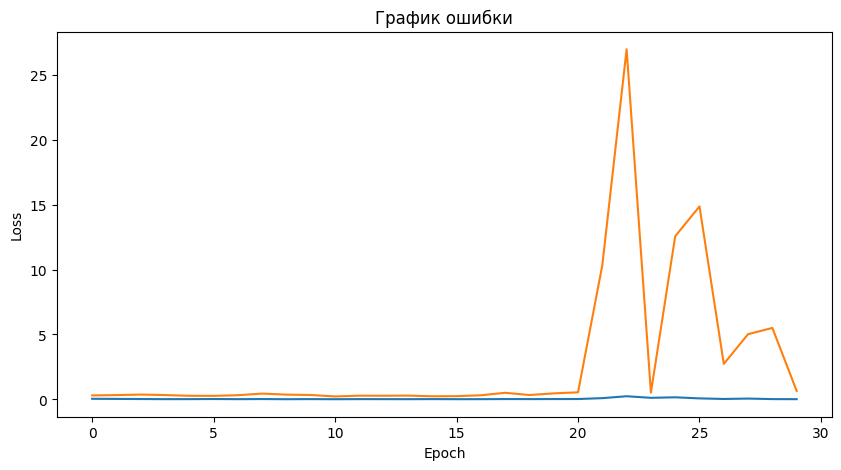

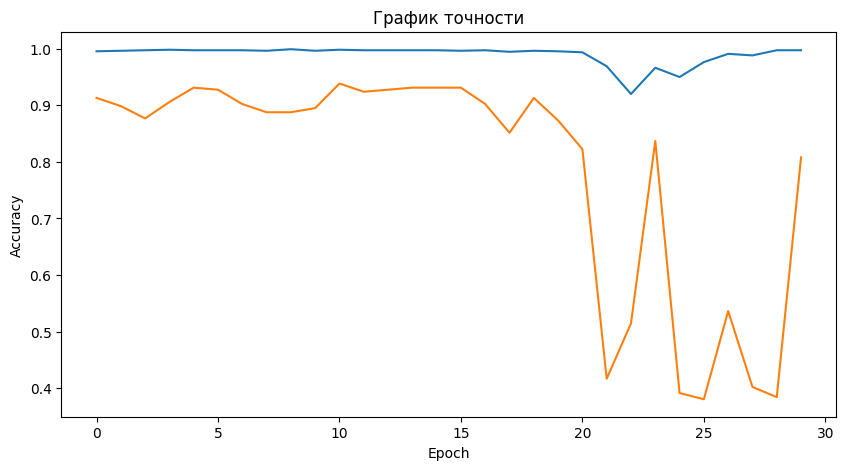

In [ ]:
# Вывод графика loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.title('График ошибки')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Вывод графика accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.title('График точности')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


## Greedy 2

Точность 0,55

In [ ]:
# Инициализируем классификатор изображений
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=3,
    objective='val_accuracy',
    directory='/content/drive/MyDrive/NetOptik',
    tuner='greedy'
)

# Подаем изображение в классификатор для обучения
clf.fit(x_train, y_train, epochs=10, batch_size=32)

# Сохраним как Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

model_tf = model.save("model_autokeras_greedy2", save_format="tf")
model_h5 = model.save("model_autokeras_greedy2.h5")


loaded_model = load_model("model_autokeras_greedy2", custom_objects=ak.CUSTOM_OBJECTS)

predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

Trial 3 Complete [00h 41m 46s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 02h 03m 56s
Epoch 1/10
42/42 [==============================] - 285s 6s/step - loss: 17.9258 - accuracy: 0.7508
Epoch 2/10
42/42 [==============================] - 259s 6s/step - loss: 18.4066 - accuracy: 0.4569
Epoch 3/10
42/42 [==============================] - 262s 6s/step - loss: 8.8794 - accuracy: 0.4585
Epoch 4/10
42/42 [==============================] - 257s 6s/step - loss: 10.8791 - accuracy: 0.3369
Epoch 5/10
42/42 [==============================] - 264s 6s/step - loss: 4.7765 - accuracy: 0.4449
Epoch 6/10
42/42 [==============================] - 257s 6s/step - loss: 12.5661 - accuracy: 0.5861
Epoch 7/10
42/42 [==============================] - 257s 6s/step - loss: 10.6085 - accuracy: 0.5944
Epoch 8/10
42/42 [==============================] - 263s 6s/step - loss: 8.2835 - accuracy: 0.2628
Epoch 9/10
42/42 [==============================] - 264s 6s/step - loss: 3.5509 - accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 22s 1s/step
[[0.0000000e+00 0.0000000e+00 9.9999994e-01]
 [1.8831486e-24 4.9958494e-24 9.9999994e-01]
 [0.0000000e+00 0.0000000e+00 9.9999994e-01]
 ...
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [2.1894655e-01 5.2726448e-01 2.5378898e-01]]


In [ ]:

history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

# Создание субплота с двумя графиками
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# График ошибки (loss)
axes[0].plot(history.history['loss'], label='Обучающая выборка')
axes[0].plot(history.history['val_loss'], label='Проверочная выборка')
axes[0].set_title('График ошибки')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# График точности (accuracy)
axes[1].plot(history.history['accuracy'], label='Обучающая выборка')
axes[1].plot(history.history['val_accuracy'], label='Проверочная выборка')
axes[1].set_title('График точности')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Размещение графиков рядом на одной горизонтальной линии
plt.tight_layout()

# Отображение графиков
plt.show()


Epoch 1/30
42/42 [==============================] - 304s 7s/step - loss: 1.4473 - accuracy: 0.4653 - val_loss: 2566.8953 - val_accuracy: 0.3613
Epoch 2/30
42/42 [==============================] - 281s 7s/step - loss: 0.7405 - accuracy: 0.6631 - val_loss: 113134.1172 - val_accuracy: 0.3493
Epoch 3/30
42/42 [==============================] - 281s 7s/step - loss: 0.8877 - accuracy: 0.7039 - val_loss: 114.5595 - val_accuracy: 0.3613
Epoch 4/30
42/42 [==============================] - 310s 7s/step - loss: 0.4842 - accuracy: 0.8150 - val_loss: 80.2013 - val_accuracy: 0.3613
Epoch 5/30
42/42 [==============================] - 285s 7s/step - loss: 0.3908 - accuracy: 0.8640 - val_loss: 11366.1084 - val_accuracy: 0.3613
Epoch 6/30
42/42 [==============================] - 285s 7s/step - loss: 0.3014 - accuracy: 0.8912 - val_loss: 911.2142 - val_accuracy: 0.3613
Epoch 7/30
42/42 [==============================] - 287s 7s/step - loss: 0.1899 - accuracy: 0.9350 - val_loss: 193.4447 - val_accuracy: 0

In [ ]:
model.save_weights('weights_greedy2_acc_0.99.h5')
model.save('model_greedy2_acc_0.99.h5')

## GREEDY 3

In [ ]:
# Инициализируем классификатор изображений
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=5,
    objective='val_accuracy',
    directory='/content/drive/MyDrive/NetOptik/GREEDY3',
    tuner='greedy'
)

# Подаем изображение в классификатор для обучения
clf.fit(x_train, y_train, epochs=10, batch_size=16)

# Сохраним как Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

model_tf = model.save("model_autokeras_greedy3", save_format="tf")
model_h5 = model.save("model_autokeras_greedy3.h5")


loaded_model = load_model("model_autokeras_greedy3", custom_objects=ak.CUSTOM_OBJECTS)

predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

Trial 5 Complete [00h 01m 36s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 07m 46s
Epoch 1/10
69/69 [==============================] - 44s 71ms/step - loss: 2.6025 - accuracy: 0.9145
Epoch 2/10
69/69 [==============================] - 6s 89ms/step - loss: 8.2746 - accuracy: 0.6815
Epoch 3/10
69/69 [==============================] - 5s 67ms/step - loss: 7.6803 - accuracy: 0.4841
Epoch 4/10
69/69 [==============================] - 4s 59ms/step - loss: 7.2751 - accuracy: 0.5041
Epoch 5/10
69/69 [==============================] - 4s 60ms/step - loss: 4.9485 - accuracy: 0.6278
Epoch 6/10
69/69 [==============================] - 5s 70ms/step - loss: 7.1753 - accuracy: 0.4659
Epoch 7/10
69/69 [==============================] - 5s 66ms/step - loss: 5.7478 - accuracy: 0.3958
Epoch 8/10
69/69 [==============================] - 4s 60ms/step - loss: 8.7133 - accuracy: 0.6715
Epoch 9/10
69/69 [==============================] - 4s 61ms/step - loss: 6.2293 - accuracy: 0.5

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 2s 87ms/step
[[4.70873273e-31 6.78821872e-36 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [1.45162488e-07 8.25505708e-08 9.99999762e-01]
 [7.90531789e-37 0.00000000e+00 1.00000000e+00]
 [3.38563084e-04 5.86682989e-04 9.99074697e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [3.63545435e-21 2.33687638e-24 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [2.35254568e-25 1.86644474e-29 1.00000000e+00]
 [6.85287960e-05 7.03363330e-05 9.99861121e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [9.95223684e-24 9.60449226e-28 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [2.89707124e-04 4.84726683e-04 9.99225616e-01]
 [3.65008629e-04 6.49905938e-04 9.98985112e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [4.71372552e-10 6.45703144e-11 1.00

Epoch 1/10
35/35 [==============================] - 52s 136ms/step - loss: 3.3658 - accuracy: 0.5150 - val_loss: 3.2190 - val_accuracy: 0.3841
Epoch 2/10
35/35 [==============================] - 3s 99ms/step - loss: 1.6132 - accuracy: 0.7106 - val_loss: 1.0586 - val_accuracy: 0.4674
Epoch 3/10
35/35 [==============================] - 3s 98ms/step - loss: 0.7453 - accuracy: 0.7825 - val_loss: 0.8139 - val_accuracy: 0.6449
Epoch 4/10
35/35 [==============================] - 4s 103ms/step - loss: 0.6174 - accuracy: 0.8071 - val_loss: 0.7499 - val_accuracy: 0.6667
Epoch 5/10
35/35 [==============================] - 4s 104ms/step - loss: 0.4784 - accuracy: 0.8571 - val_loss: 3.9171 - val_accuracy: 0.5471
Epoch 6/10
35/35 [==============================] - 4s 101ms/step - loss: 0.4233 - accuracy: 0.8562 - val_loss: 2.3140 - val_accuracy: 0.6739
Epoch 7/10
35/35 [==============================] - 3s 99ms/step - loss: 0.4413 - accuracy: 0.8826 - val_loss: 5.9118 - val_accuracy: 0.6159
Epoch 8/

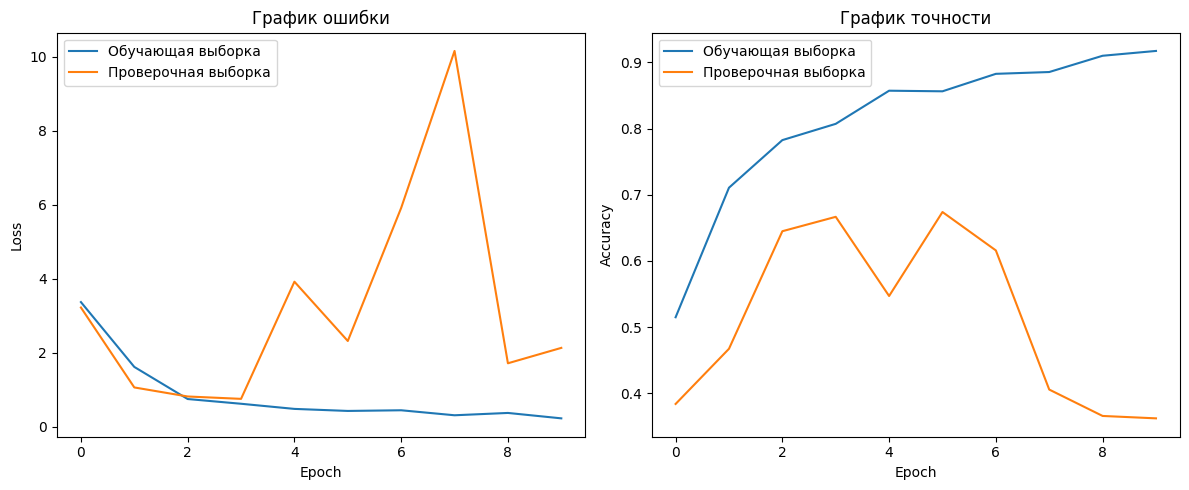

In [ ]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Создание субплота с двумя графиками
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# График ошибки (loss)
axes[0].plot(history.history['loss'], label='Обучающая выборка')
axes[0].plot(history.history['val_loss'], label='Проверочная выборка')
axes[0].set_title('График ошибки')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# График точности (accuracy)
axes[1].plot(history.history['accuracy'], label='Обучающая выборка')
axes[1].plot(history.history['val_accuracy'], label='Проверочная выборка')
axes[1].set_title('График точности')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Размещение графиков рядом на одной горизонтальной линии
plt.tight_layout()

# Отображение графиков
plt.show()

In [ ]:
model.save_weights('weights_greedy2_acc_0.99.h5')
model.save('model_greedy2_acc_0.99.h5')

## Прочие пока неудачные обработки с Autokeras

In [ ]:
# Инициализируем классификатор изображений
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=3,
    objective='val_accuracy',
    #augment=True,             # так встроить аугментацию не получилось
    tuner='greedy'
)

# Подаем изображение в классификатор для обучения
clf.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.15)

# Сохраним как Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("model_autokeras_greedy2", save_format="tf")
except Exception:
    model.save("model_autokeras_greedy2.h5")


loaded_model = load_model("model_autokeras_greedy2", custom_objects=ak.CUSTOM_OBJECTS)

predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

Trial 3 Complete [00h 02m 56s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 07m 03s
Epoch 1/30
35/35 [==============================] - 44s 95ms/step - loss: 22.7093 - accuracy: 0.6652
Epoch 2/30
35/35 [==============================] - 3s 93ms/step - loss: 12.4115 - accuracy: 0.5450
Epoch 3/30
35/35 [==============================] - 3s 92ms/step - loss: 8.3833 - accuracy: 0.5769
Epoch 4/30
35/35 [==============================] - 3s 91ms/step - loss: 8.3615 - accuracy: 0.6269
Epoch 5/30
35/35 [==============================] - 3s 95ms/step - loss: 8.3884 - accuracy: 0.8107
Epoch 6/30
35/35 [==============================] - 3s 95ms/step - loss: 7.5858 - accuracy: 0.6752
Epoch 7/30
35/35 [==============================] - 3s 92ms/step - loss: 10.6976 - accuracy: 0.1156
Epoch 8/30
35/35 [==============================] - 3s 92ms/step - loss: 7.6093 - accuracy: 0.0737
Epoch 9/30
35/35 [==============================] - 3s 94ms/step - loss: 3.9439 - accuracy: 

In [ ]:
print(clf.evaluate(x_val, y_val))

9/9 [==============================] - 1s 36ms/step - loss: 1.2728 - accuracy: 0.2862
[1.2728397846221924, 0.2862318754196167]


In [ ]:
# дообучаем лучшую модель
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
35/35 [==============================] - 5s 131ms/step - loss: 0.7304 - accuracy: 0.7325 - val_loss: 15514.5811 - val_accuracy: 0.3623
Epoch 2/10
35/35 [==============================] - 4s 103ms/step - loss: 0.5327 - accuracy: 0.8317 - val_loss: 4559.7856 - val_accuracy: 0.3623
Epoch 3/10
35/35 [==============================] - 4s 104ms/step - loss: 0.4055 - accuracy: 0.8562 - val_loss: 11365.0225 - val_accuracy: 0.3623
Epoch 4/10
35/35 [==============================] - 4s 101ms/step - loss: 0.3781 - accuracy: 0.8790 - val_loss: 28.5366 - val_accuracy: 0.3623
Epoch 5/10
35/35 [==============================] - 4s 101ms/step - loss: 0.2226 - accuracy: 0.9190 - val_loss: 1.3156 - val_accuracy: 0.8913
Epoch 6/10
35/35 [==============================] - 4s 101ms/step - loss: 0.1710 - accuracy: 0.9436 - val_loss: 4.6727 - val_accuracy: 0.3732
Epoch 7/10
35/35 [==============================] - 4s 103ms/step - loss: 0.1617 - accuracy: 0.9481 - val_loss: 12.8096 - val_accuracy: 

In [ ]:
model.save_weights('weights_greedy1_acc_0.99.h5')
model.save('model_greedy1_acc_0.99.h5')

In [ ]:
# Инициализируем классификатор изображений
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=3,
    objective='val_accuracy',
    tuner='greedy'
)

# Подаем изображение в классификатор для обучения
clf.fit(x_train, y_train, epochs=10, batch_size=32)

# Сохраним как Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("model_autokeras_greedy2", save_format="tf")
except Exception:
    model.save("model_autokeras_greedy2.h5")


loaded_model = load_model("model_autokeras_greedy2", custom_objects=ak.CUSTOM_OBJECTS)

predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

Trial 3 Complete [00h 01m 24s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 04m 29s
Epoch 1/10
35/35 [==============================] - 41s 91ms/step - loss: 19.6469 - accuracy: 0.6724
Epoch 2/10
35/35 [==============================] - 3s 89ms/step - loss: 14.1617 - accuracy: 0.5951
Epoch 3/10
35/35 [==============================] - 3s 91ms/step - loss: 29.6688 - accuracy: 0.4832
Epoch 4/10
35/35 [==============================] - 3s 91ms/step - loss: 12.7189 - accuracy: 0.3330
Epoch 5/10
35/35 [==============================] - 3s 90ms/step - loss: 12.2824 - accuracy: 0.1365
Epoch 6/10
35/35 [==============================] - 3s 93ms/step - loss: 8.2909 - accuracy: 0.1228
Epoch 7/10
35/35 [==============================] - 3s 91ms/step - loss: 7.0959 - accuracy: 0.2284
Epoch 8/10
35/35 [==============================] - 3s 92ms/step - loss: 10.5851 - accuracy: 0.3685
Epoch 9/10
35/35 [==============================] - 3s 93ms/step - loss: 5.1810 - accurac

<class 'keras.engine.functional.Functional'>


ValueError: ignored

In [ ]:
# Создание списка обратных вызовов для отслеживания метрик
callbacks = [
    keras.callbacks.History(),  # для сохранения истории метрик
    keras.callbacks.EarlyStopping(patience=3),  # для ранней остановки
]

# Обучение модели с использованием обратных вызовов
history = clf.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=callbacks)

# Вывод графика val_loss
plt.plot(history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Вывод графика val_accuracy
plt.plot(history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:

# Export as a Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("model_autokeras_greedy1", save_format="tf")
except Exception:
    model.save("model_autokeras_greedy1.h5")


loaded_model = load_model("model_autokeras_greedy1", custom_objects=ak.CUSTOM_OBJECTS)

predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

OSError: ignored

код для запуска AutoKeras с использованием train_generator:

In [ ]:
import autokeras as ak

# Создание экземпляра класса ImageClassifier
clf = ak.ImageClassifier(
    tuner="greedy",  # Указываем использование тюнера greedy
    overwrite=True  # Перезаписываем модель при каждом запуске
)

# Загрузка данных и создание генератора
train_generator = datagen.flow_from_directory(
    x_train, y_train,
    target_size=(640, 448),  # Размер изображений (при необходимости)
    batch_size=32,
    class_mode='categorical')  # Ваш генератор для обучающей выборки
validation_generator = datagen.flow_from_directory(
    x_val, y_val,
    target_size=(640, 448),
    batch_size=32,
    class_mode='categorical') # Ваш генератор для проверочной выборки

# Обучение модели с использованием тюнера
clf.fit(train_generator, validation_data=validation_generator)

# Оценка модели
loss, accuracy = clf.evaluate(validation_generator)

print('Validation Loss:', loss)
print('Validation Accuracy:', accuracy)

ValueError: ignored

Метод flow_from_directory автоматически извлекает метки классов из структуры папок и возвращает их в виде массива NumPy. В приведенном примере кода y_train и y_valid будут содержать метки классов соответствующих образцов изображений в train_data_dir и valid_data_dir соответственно.

Обратите внимание, что y_train и y_valid будут представлены в виде массива одномерных меток классов. Если вы используете функцию потерь, которая требует кодирования меток в формате "one-hot encoding", вы можете использовать функцию to_categorical из модуля tensorflow.keras.utils для преобразования меток классов в соответствующий формат.

In [ ]:
# Создание объекта ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Пути к папкам с данными
train_data_dir = 'glasses_images/glasses_img'
valid_data_dir = 'glasses_images/val_img'

# Загрузка и предобработка данных с помощью ImageDataGenerator
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(112, 84),  # Размер изображений (при необходимости)
    batch_size=32,
    class_mode='categorical')

valid_generator = datagen.flow_from_directory(
    valid_data_dir,
    target_size=(112, 84),
    batch_size=32,
    class_mode='categorical')

# Получение меток классов для train_generator
y_train = train_generator.classes

# Получение меток классов для valid_generator
y_valid = valid_generator.classes

# Проверка размерностей y_train и y_valid
print(y_train.shape)
print(y_valid.shape)

Found 1132 images belonging to 3 classes.
Found 282 images belonging to 3 classes.
(1132,)
(282,)


In [ ]:
# Создание объекта ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Пути к папкам с данными
train_data_dir = 'glasses_images/glasses_img'
valid_data_dir = 'glasses_images/validation'

# Загрузка и предобработка данных с помощью ImageDataGenerator
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  # Размер изображений (при необходимости)
    batch_size=32,
    class_mode='categorical')

# Получение размеров изображений
sample_images, _ = next(train_generator)
image_shape = sample_images.shape[1:]  # Получаем размеры изображений


# Создание и обучение модели AutoKeras
clf = ak.ImageClassifier()
clf.fit(train_generator)

# Оценка качества модели на проверочном наборе
accuracy = clf.evaluate(valid_data_dir)
print('Accuracy:', accuracy)

Found 1132 images belonging to 3 classes.


AttributeError: ignored

Создадим y_train.

# Autokeras with ImageDataGenerator

In [ ]:
# Загрузка данных
train_images_dir = '/content/train_folder'
train_labels_dir = y_train

test_images_dir = '/content/val_folder'
test_labels_dir = y_val

# Создание генератора данных с аугментацией
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,                      # нормализация данных
    rotation_range=10,                      # произвольное вращение рандомно от 0 до 10 градусов
    width_shift_range=0.1,                  # сдвиг изображения по ширине (горизонтали)
    height_shift_range=0.1,                 # сдвиг изображения по высоте (вертикали)
    brightness_range= (0.1,0.4),            # регулирование яркости
    shear_range=0.1,                        # интенсивность сдвига по оси x
    zoom_range=0.1,                         # регулируем масштаб изображения
    horizontal_flip=True,                   # отзеркаливание по горизонтали
    fill_mode='nearest'                     # пропущенные при преобразовании пиксели будут заполнены из ближайших позиций
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)


In [ ]:
# Загрузка данных с использованием генератора
train_data = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(112, 84),
    batch_size=32,
    class_mode='categorical',
    seed=123
)

test_data = test_datagen.flow_from_directory(
    test_images_dir,
    target_size=(112, 84),
    batch_size=32,
    class_mode='categorical',
    seed=123
)


Found 1099 images belonging to 3 classes.
Found 276 images belonging to 3 classes.


In [ ]:
print(train_data.image_shape)
print(test_data.image_shape)

(112, 84, 3)
(112, 84, 3)


In [ ]:
# Создание и обучение модели
clf = ak.ImageClassifier(max_trials=1)
clf.fit(train_data, train_labels_dir, epochs=10, validation_data=test_data)

# Оценка модели
results = clf.evaluate(test_data)
print(results)


AttributeError: ignored

In [ ]:
# Инициализируем классификатор изображений
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=3,
    objective='val_accuracy',
    tuner='greedy'
)

# Подаем изображение в классификатор для обучения
clf.fit_generator(train_data, epochs=10, validation_data=test_data)

# Сохраним как Keras Model.
model = clf.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("model_autokeras_greedy+augm", save_format="tf")
except Exception:
    model.save("model_autokeras_greedy+augm.h5")


loaded_model = load_model("model_autokeras_greedy+augm", custom_objects=ak.CUSTOM_OBJECTS)

predicted_y = loaded_model.predict(tf.expand_dims(x_val, -1))
print(predicted_y)

# Automodel вместо ImageClassifier

3 запуска - везде низкие результаты

In [ ]:
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # нормализуем данные
    normalize=True,
    # Автоматическая аугментация данных.
    augment=True,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=3
)
clf.fit(x_train, y_train, epochs=50, validation_split=0.15)

# Распознавание лучшей модели.
predicted_y = clf.predict(x_val)
print(predicted_y)


# Итоги лучшей модели
print(clf.evaluate(x_val, y_val))


Trial 3 Complete [00h 01m 24s]
val_loss: 0.0

Best val_loss So Far: 0.0
Total elapsed time: 00h 04m 25s
Epoch 1/10
35/35 [==============================] - 41s 102ms/step - loss: 25.5439 - accuracy: 0.5951
Epoch 2/10
35/35 [==============================] - 4s 101ms/step - loss: 16.3005 - accuracy: 0.3658
Epoch 3/10
35/35 [==============================] - 3s 96ms/step - loss: 16.5634 - accuracy: 0.5669
Epoch 4/10
35/35 [==============================] - 3s 97ms/step - loss: 21.9207 - accuracy: 0.6924
Epoch 5/10
35/35 [==============================] - 3s 98ms/step - loss: 11.8274 - accuracy: 0.3576
Epoch 6/10
35/35 [==============================] - 4s 102ms/step - loss: 7.7709 - accuracy: 0.4049
Epoch 7/10
35/35 [==============================] - 4s 102ms/step - loss: 7.3453 - accuracy: 0.2147
Epoch 8/10
35/35 [==============================] - 3s 99ms/step - loss: 11.3865 - accuracy: 0.3885
Epoch 9/10
35/35 [==============================] - 3s 98ms/step - loss: 5.7915 - accuracy: 0

In [ ]:
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ImageAugmentation(horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_factor=True,
                                   zoom_factor=True
                                  )(output_node)
output_node = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)

clf.fit(x_train, y_train, epochs=10, validation_split=0.15)

# Predict with the best model.
predicted_y = clf.predict(x_val)
print(predicted_y)


# Evaluate the best model with testing data.
print(clf.evaluate(x_val, y_val))

Trial 1 Complete [00h 02m 18s]
val_loss: 2.761485689006804e-07

Best val_loss So Far: 2.761485689006804e-07
Total elapsed time: 00h 02m 18s
Epoch 1/10
35/35 [==============================] - 44s 323ms/step - loss: 36.5065 - accuracy: 0.4258
Epoch 2/10
35/35 [==============================] - 10s 290ms/step - loss: 10.0878 - accuracy: 0.5259
Epoch 3/10
35/35 [==============================] - 10s 292ms/step - loss: 22.8604 - accuracy: 0.3803
Epoch 4/10
35/35 [==============================] - 10s 283ms/step - loss: 7.8513 - accuracy: 0.3203
Epoch 5/10
35/35 [==============================] - 10s 277ms/step - loss: 7.8617 - accuracy: 0.4322
Epoch 6/10
35/35 [==============================] - 10s 275ms/step - loss: 7.4422 - accuracy: 0.2166
Epoch 7/10
35/35 [==============================] - 10s 272ms/step - loss: 2.7602 - accuracy: 0.1647
Epoch 8/10
35/35 [==============================] - 10s 275ms/step - loss: 2.2650 - accuracy: 0.1965
Epoch 9/10
35/35 [==============================]

In [ ]:
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # нормализуем данные
    normalize=True,
    # Автоматическая аугментация данных.
    augment=True,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=3
)
clf.fit(x_train, y_train, epochs=50, validation_split=0.15)

# Распознавание лучшей модели.
predicted_y = clf.predict(x_val)
print(predicted_y)


# Итоги лучшей модели
print(clf.evaluate(x_val, y_val))


Trial 3 Complete [00h 01m 42s]
val_loss: 0.0

Best val_loss So Far: 0.0
Total elapsed time: 00h 05m 03s
Epoch 1/50
35/35 [==============================] - 40s 94ms/step - loss: 26.5028 - accuracy: 0.6761
Epoch 2/50
35/35 [==============================] - 3s 97ms/step - loss: 16.0180 - accuracy: 0.1456
Epoch 3/50
35/35 [==============================] - 3s 93ms/step - loss: 10.8218 - accuracy: 0.0027
Epoch 4/50
35/35 [==============================] - 3s 96ms/step - loss: 2.7336 - accuracy: 0.2693
Epoch 5/50
35/35 [==============================] - 3s 98ms/step - loss: 7.1548 - accuracy: 0.1492
Epoch 6/50
35/35 [==============================] - 3s 96ms/step - loss: 5.2193 - accuracy: 0.1410
Epoch 7/50
35/35 [==============================] - 3s 94ms/step - loss: 5.9413 - accuracy: 0.1483
Epoch 8/50
35/35 [==============================] - 3s 93ms/step - loss: 3.2121 - accuracy: 0.2157
Epoch 9/50
35/35 [==============================] - 3s 92ms/step - loss: 3.8102 - accuracy: 0.2784
E